## Objective: Image Classification using Convolutional Neural Networks in PyTorch

### Reference: https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-4-image-classification-with-cnn

In [1]:
# Imports
import torch
import torchvision

In [2]:
# Download dataset
from torchvision.datasets.utils import download_url

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
# Extracting dataset
import tarfile

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
# dataset directory
import os

data_dir = './data/cifar10'
classes = os.listdir(data_dir + "/train")

In [5]:
# Since the dataset is in PIL we convert to tensor to perform operation
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform = ToTensor())
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Label: airplane (0)


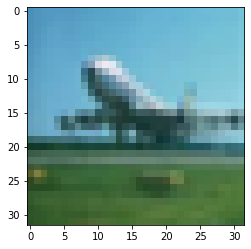

In [6]:
# displaying sample image from dataset
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img,label):
    print('Label:', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
    plt.show()

show_example(*dataset[100])

In [7]:
# splitting dataset in training and validation dataset
from torch.utils.data import random_split

random_seed = 0
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [8]:
# Splitting training and validation data into batches
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

batchsize = 128

train_dl = DataLoader(train_ds, batchsize, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batchsize*2, num_workers=2, pin_memory=True)

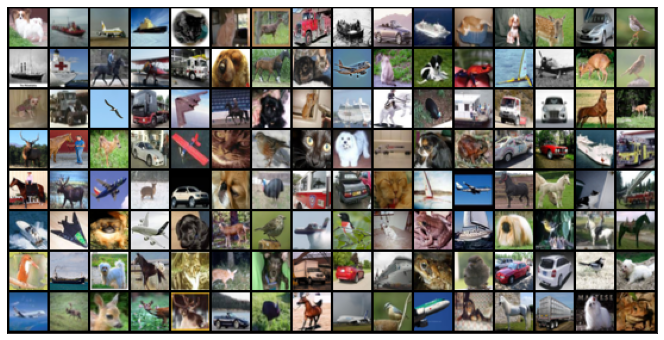

In [9]:
# displaying one batch of images
def show_batch(dl):
    for images, label in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class Cifar10CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self, xb):
        return self.network(xb)

model = Cifar10CNNModel()

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = to_device(Cifar10CNNModel(), device)

In [17]:
evaluate(model, val_dl)

{'val_loss': 2.3030731678009033, 'val_acc': 0.1061810702085495}

In [18]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [19]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7576, val_loss: 1.4085, val_acc: 0.4843
Epoch [1], train_loss: 1.2249, val_loss: 1.0447, val_acc: 0.6238
Epoch [2], train_loss: 0.9522, val_loss: 0.8957, val_acc: 0.6832
Epoch [3], train_loss: 0.7713, val_loss: 0.8061, val_acc: 0.7203
Epoch [4], train_loss: 0.6355, val_loss: 0.6954, val_acc: 0.7542
Epoch [5], train_loss: 0.5192, val_loss: 0.8257, val_acc: 0.7259
Epoch [6], train_loss: 0.4132, val_loss: 0.7145, val_acc: 0.7727
Epoch [7], train_loss: 0.3166, val_loss: 0.7712, val_acc: 0.7720
Epoch [8], train_loss: 0.2359, val_loss: 0.9129, val_acc: 0.7539
Epoch [9], train_loss: 0.1886, val_loss: 0.9906, val_acc: 0.7593
Epoch [10], train_loss: 0.1476, val_loss: 1.1624, val_acc: 0.7624
Epoch [11], train_loss: 0.1127, val_loss: 1.2051, val_acc: 0.7581
Epoch [12], train_loss: 0.1053, val_loss: 1.1684, val_acc: 0.7583
Epoch [13], train_loss: 0.0915, val_loss: 1.2905, val_acc: 0.7583
Epoch [14], train_loss: 0.0928, val_loss: 1.2888, val_acc: 0.7629


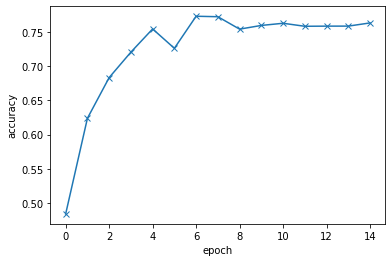

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    #plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

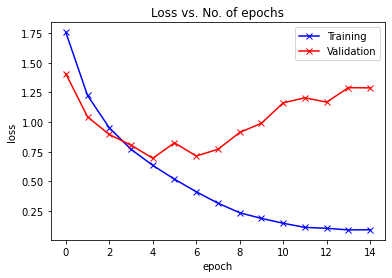

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [22]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


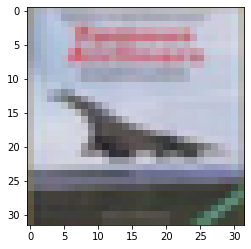

In [24]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [25]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batchsize*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.2952200174331665, 'val_acc': 0.7557617425918579}